# Plotting Examples

Demonstrate the plotting functions in `bossdata.plot`.

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.io.fits as fits

/Users/david/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import bossdata
print bossdata.__version__

0.2.7dev


In [4]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

## Targeting Metadata

In [5]:
spAll = bossdata.meta.Database(finder=finder, mirror=mirror, lite=False)

In [6]:
def get_targets(plate, mjd):
    return spAll.select_all(what='XFOCAL,YFOCAL,FIBER,OBJTYPE,CLASS',
                            where='PLATE={plate} and MJD={mjd}'.format(plate=plate, mjd=mjd))

In [7]:
plate6640 = get_targets(6640, 56385)
std6640 = plate6640['OBJTYPE'] == 'SPECTROPHOTO_STD'
sky6640 = plate6640['OBJTYPE'] == 'SKY'

## Flux Calibration Vectors

Load the spFluxcalib or spFluxcorr vector for all fibers of a single exposure in the blue or red cameras:

In [8]:
def get_calib_vector(plate, mjd, ftype, exposure_index, camera='blue'):
    num_fibers = bossdata.plate.get_num_fibers(plate)
    # Load the list of exposures used to co-add this observation.
    plan_name = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    plan_file = bossdata.plate.Plan(mirror.get(plan_name))
    spec1_name = plan_file.get_exposure_name(exposure_index, camera, 1, ftype)
    spec2_name = plan_file.get_exposure_name(exposure_index, camera, num_fibers, ftype)
    if spec1_name is None or spec2_name is None:
        print 'Missing {} exposures [{}] for {}-{}.'.format(camera, exposure_index, plate, mjd)
        return
    exposure_id = plan_file.exposures['science'][exposure_index]['EXPID']
    print 'Exposure [{}] is #{}.'.format(exposure_index, exposure_id)
    spec1_file = fits.open(mirror.get(finder.get_plate_path(plate, spec1_name)))
    spec2_file = fits.open(mirror.get(finder.get_plate_path(plate, spec2_name)))
    return np.vstack((spec1_file[0].data, spec2_file[0].data))

In [9]:
corr6640_0 = get_calib_vector(6640, 56385, 'spFluxcorr', 0, 'blue')
corr6640_1 = get_calib_vector(6640, 56385, 'spFluxcorr', 1, 'blue')
corr6640_2 = get_calib_vector(6640, 56385, 'spFluxcorr', 2, 'blue')

Exposure [0] is #159423.
Exposure [1] is #159424.
Exposure [2] is #159425.


In [10]:
calib6640_0 = get_calib_vector(6640, 56385, 'spFluxcalib', 0, 'blue')
calib6640_1 = get_calib_vector(6640, 56385, 'spFluxcalib', 1, 'blue')
calib6640_2 = get_calib_vector(6640, 56385, 'spFluxcalib', 2, 'blue')

Exposure [0] is #159423.
Exposure [1] is #159424.
Exposure [2] is #159425.


## Flux Calibration Plots

Define the special subsets to identify in the plots.

In [11]:
subsets = {
    'Standards': { 'options': dict(marker='*', s=250), 'fibers': std6640 },
    'Sky': { 'options': dict(marker='s'), 'fibers': sky6640 }
}

Plot flux calibration vectors (left) and correction factors (right) for the first three exposures of 6640-56385:

/Users/david/anaconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


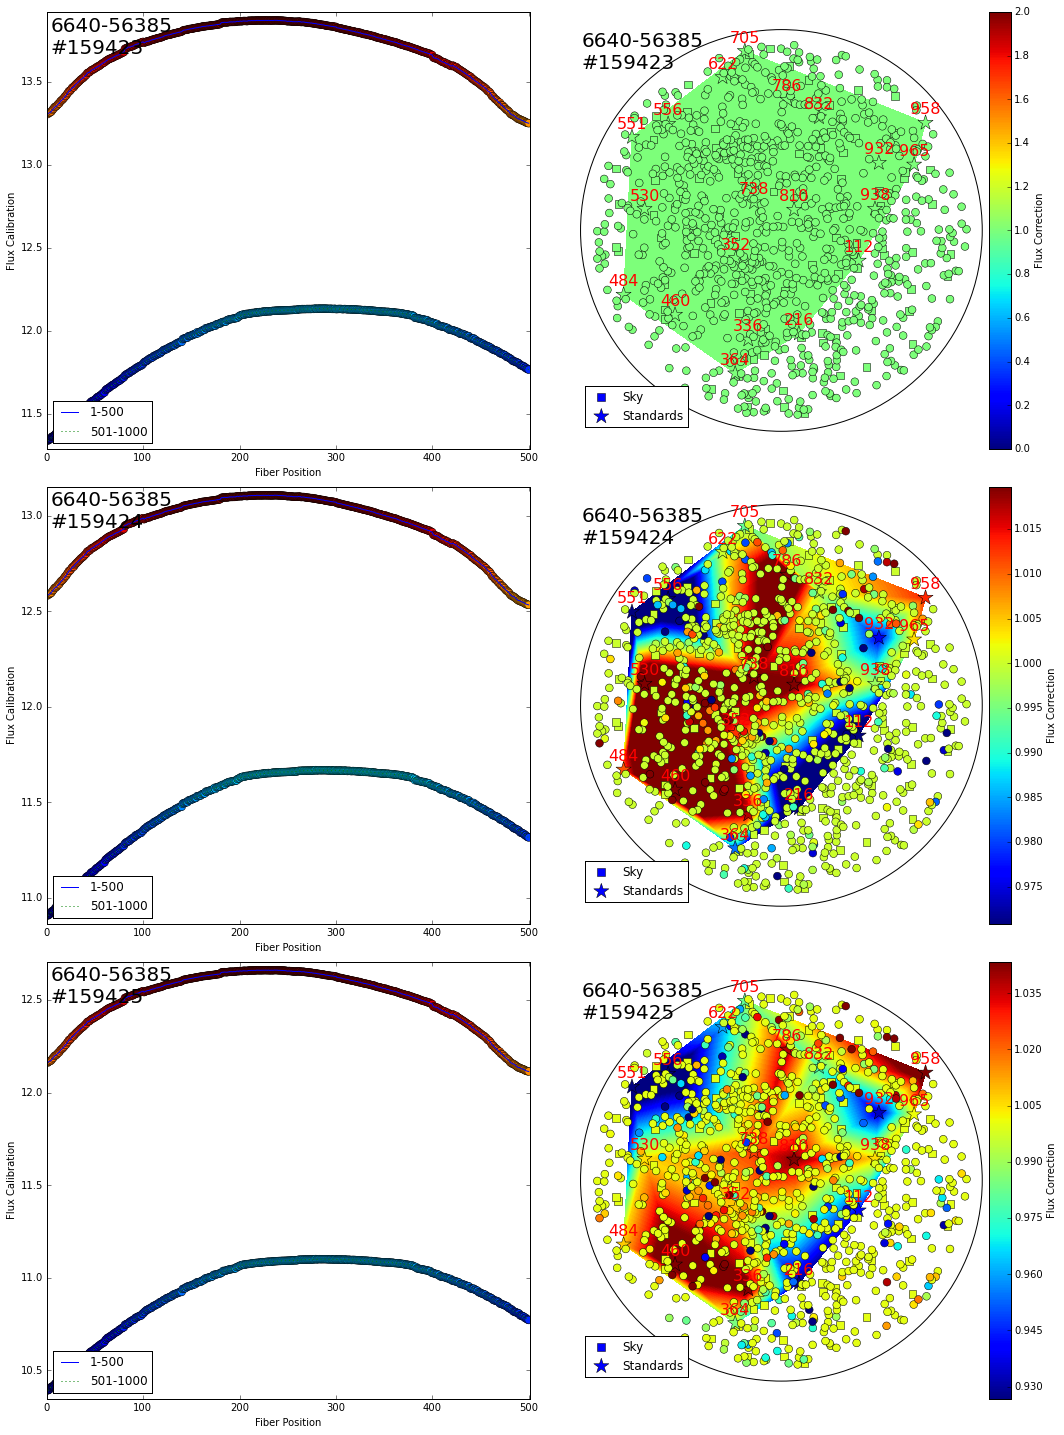

In [12]:
fig = plt.figure(figsize=(15, 20))
wlen = 1000
#
plt.subplot(3,2,1)
bossdata.plot.by_fiber(calib6640_0[:,wlen], percentile_cut=0,
                       plot_label='6640-56385\n#159423', data_label='Flux Calibration')
plt.subplot(3,2,2)
bossdata.plot.focal_plane(plate6640['XFOCAL'], plate6640['YFOCAL'], corr6640_0[:,wlen], percentile_cut=2,
                          background=std6640, subsets=subsets, numbered=std6640,
                          plot_label='6640-56385\n#159423', data_label='Flux Correction')
#
plt.subplot(3,2,3)
bossdata.plot.by_fiber(calib6640_1[:,wlen], percentile_cut=0,
                       plot_label='6640-56385\n#159424', data_label='Flux Calibration')
plt.subplot(3,2,4)
bossdata.plot.focal_plane(plate6640['XFOCAL'], plate6640['YFOCAL'], corr6640_1[:,wlen], percentile_cut=2,
                          background=std6640, subsets=subsets, numbered=std6640,
                          plot_label='6640-56385\n#159424', data_label='Flux Correction')
#
plt.subplot(3,2,5)
bossdata.plot.by_fiber(calib6640_2[:,wlen], percentile_cut=0,
                       plot_label='6640-56385\n#159425', data_label='Flux Calibration')
plt.subplot(3,2,6)
bossdata.plot.focal_plane(plate6640['XFOCAL'], plate6640['YFOCAL'], corr6640_2[:,wlen], percentile_cut=2,
                          background=std6640, subsets=subsets, numbered=std6640,
                          plot_label='6640-56385\n#159425', data_label='Flux Correction')
#
plt.tight_layout()
plt.show()